In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import yfinance as yf 
from scipy.optimize import root
from scipy.stats import norm, t

import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
formatter = mdates.DateFormatter("%Y-%m-%d")

# **PUBLIC BDCs PRICE vs NAV**


## **Download financial statements from the SEC EDGAR website**


<font size="3"> The SEC has a comprehensive database where you can download the financial statements for public listed companies. It is called EDGAR and you can download 10-Q or 10-K reports easily. In the following script you can watch how to do it. <br><br> 

In [2]:
#DOWNLOAD FINANCIAL STATEMENTS
#You can search cik codes in the following link -> https://www.sec.gov/edgar/searchedgar/cik.htm

headers = { 'User-Agent': 'Mozilla/5.0', } 

#CIKs for Ares Capital Corporation and FS KKR Capital Corp
CIK1 = '0001287750' # -> Ares Capital Corporation
CIK2 = '0001422183' # -> FS KKR Capital Corp

#Download information
download1 = requests.get('https://data.sec.gov/api/xbrl/companyfacts/CIK'+CIK1+'.json', stream=True, headers = headers)
download2 = requests.get('https://data.sec.gov/api/xbrl/companyfacts/CIK'+CIK2+'.json', stream=True, headers = headers)
fin_statment1 = download1.json()
fin_statment2 = download2.json()

#Extract US-Gaap accounting ledgers
us_gaap_concepts1 = list(fin_statment1['facts']['us-gaap'].keys())
us_gaap_concepts2 = list(fin_statment2['facts']['us-gaap'].keys())

In [3]:
#NetAssetValuePerShare
NetAssetValuePerShare_list1 = fin_statment1['facts']['us-gaap']['NetAssetValuePerShare']['units']['USD/shares']
NetAssetValuePerShare_df1 = pd.DataFrame(NetAssetValuePerShare_list1)
NetAssetValuePerShare_df1['end'] = pd.to_datetime(NetAssetValuePerShare_df1['end'])
NetAssetValuePerShare_df1 = NetAssetValuePerShare_df1.dropna()
NetAssetValuePerShare_df1 = NetAssetValuePerShare_df1[NetAssetValuePerShare_df1['frame'].str.contains('CY')]
NetAssetValuePerShare_df1 = NetAssetValuePerShare_df1[(NetAssetValuePerShare_df1['end']>=datetime(2020, 6, 30))&(NetAssetValuePerShare_df1['end']<=datetime(2023, 3, 31))]

NetAssetValuePerShare_list2 = fin_statment2['facts']['us-gaap']['NetAssetValuePerShare']['units']['USD/shares']
NetAssetValuePerShare_df2 = pd.DataFrame(NetAssetValuePerShare_list2)
NetAssetValuePerShare_df2['end'] = pd.to_datetime(NetAssetValuePerShare_df2['end'])
NetAssetValuePerShare_df2 = NetAssetValuePerShare_df2.dropna()
NetAssetValuePerShare_df2 = NetAssetValuePerShare_df2[NetAssetValuePerShare_df2['frame'].str.contains('CY')]
NetAssetValuePerShare_df2 = NetAssetValuePerShare_df2[(NetAssetValuePerShare_df2['end']>=datetime(2020, 6, 30))&(NetAssetValuePerShare_df2['end']<=datetime(2023, 3, 31))]

#Assets
Assets_list1= fin_statment1['facts']['us-gaap']['Assets']['units']['USD']
Assets_df1 = pd.DataFrame(Assets_list1)
Assets_df1['end'] = pd.to_datetime(Assets_df1['end'])
Assets_df1 = Assets_df1.dropna()
Assets_df1 = Assets_df1[Assets_df1['frame'].str.contains('CY')]
Assets_df1 = Assets_df1[(Assets_df1['end']>=datetime(2010, 6, 30))&(Assets_df1['end']<=datetime(2023, 6, 30))]

Assets_list2= fin_statment2['facts']['us-gaap']['Assets']['units']['USD']
Assets_df2 = pd.DataFrame(Assets_list2)
Assets_df2['end'] = pd.to_datetime(Assets_df2['end'])
Assets_df2 = Assets_df2.dropna()
Assets_df2 = Assets_df2[Assets_df1['frame'].str.contains('CY')]
Assets_df2 = Assets_df2[(Assets_df1['end']>=datetime(2010, 6, 30))&(Assets_df2['end']<=datetime(2023, 6, 30))]

#Liabilities
Liabilities_list1 = fin_statment1['facts']['us-gaap']['Liabilities']['units']['USD']
Liabilities_df1 = pd.DataFrame(Liabilities_list1)
Liabilities_df1['end'] = pd.to_datetime(Liabilities_df1['end'])
Liabilities_df1 = Liabilities_df1.dropna()
Liabilities_df1 = Liabilities_df1[Liabilities_df1['frame'].str.contains('CY')]
Liabilities_df1 = Liabilities_df1[(Liabilities_df1['end']>=datetime(2010, 6, 30))&(Liabilities_df1['end']<=datetime(2023, 6, 30))]

Liabilities_list2 = fin_statment2['facts']['us-gaap']['Liabilities']['units']['USD']
Liabilities_df2 = pd.DataFrame(Liabilities_list2)
Liabilities_df2['end'] = pd.to_datetime(Liabilities_df2['end'])
Liabilities_df2 = Liabilities_df2.dropna()
Liabilities_df2 = Liabilities_df2[Liabilities_df2['frame'].str.contains('CY')]
Liabilities_df2 = Liabilities_df2[(Liabilities_df2['end']>=datetime(2010, 6, 30))&(Liabilities_df2['end']<=datetime(2023, 6, 30))]


## **Download the price history**


<font size="3"> You can use the yahoo finance API to download the company's stock's price history. This is shown in the following script <br><br> 

In [4]:
#DOWNLOAD HISTORIC STOCK PRICES
Ticker1 = 'ARCC'

prices1 = yf.Ticker(Ticker1)
prices_hist1 = prices1.history(period="max")
df1 = prices_hist1
df1.reset_index(inplace=True)
df1 = df1[df1['Date']>=datetime(2020, 6, 30)]
df1['Date'] = pd.to_datetime(df1['Date'], utc=True).dt.date
df1['Date'] = pd.to_datetime(df1['Date'])

Ticker2 = 'FSK'

prices2 = yf.Ticker(Ticker2)
prices_hist2 = prices2.history(period="max")
df2 = prices_hist2
df2.reset_index(inplace=True)
df2 = df2[df2['Date']>=datetime(2020, 6, 30)]
df2['Date'] = pd.to_datetime(df2['Date'], utc=True).dt.date
df2['Date'] = pd.to_datetime(df2['Date'])

## **Create a single dataframe**


<font size="3"> Now we order all the information into a single dataframe. We need the information of current and non current liabilities, the number of shares and the price to calculate market capitalizarion and the volatility of the stock price <br><br> 

In [5]:
#Create a single DataFrame

#Merge number 1
df_final1 = pd.merge(df1,
                        NetAssetValuePerShare_df1[['end','val']], 
                        left_on='Date',
                        right_on='end',
                       how = 'left'
                        )


df_final1['val'].fillna(method='ffill',inplace=True)
df_final1['price_vs_nav'] = df_final1['Close']/df_final1['val']
df_final1 = df_final1[['Date','Close','val','price_vs_nav']]


#Merge number 1
df_final2 = pd.merge(df2,
                        NetAssetValuePerShare_df2[['end','val']], 
                        left_on='Date',
                        right_on='end',
                       how = 'left'
                        )


df_final2['val'].fillna(method='ffill',inplace=True)
df_final2['price_vs_nav'] = df_final2['Close']/df_final2['val']
df_final2 = df_final2[['Date','Close','val','price_vs_nav']]

## **Chart**

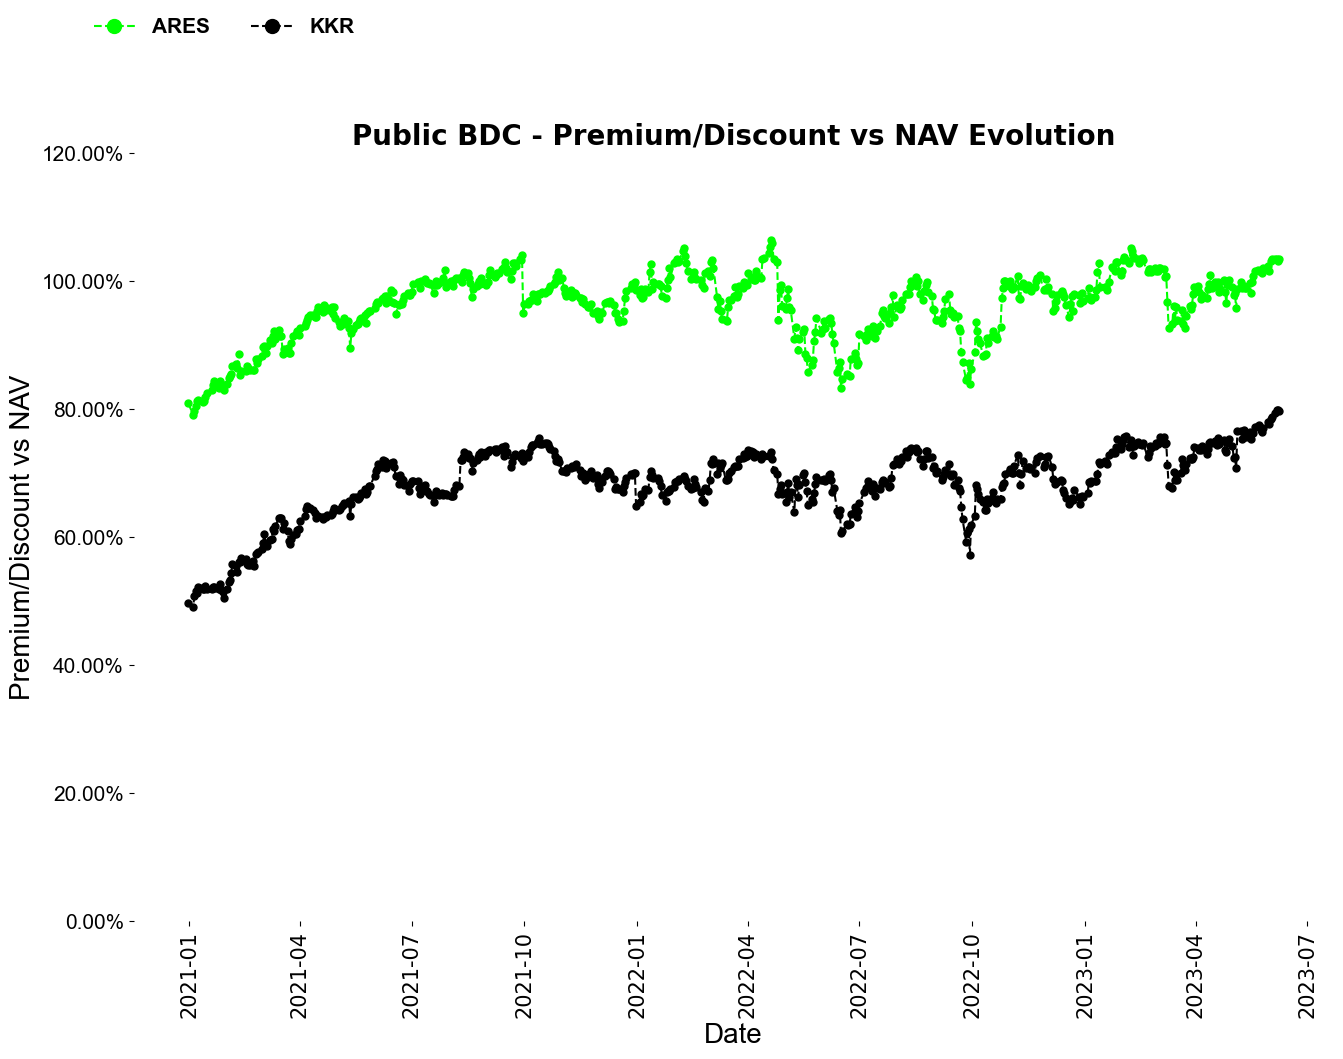

In [8]:
#Create chart - price vs NAV
fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

font = font_manager.FontProperties(family='Arial',weight='bold', style='normal', size=15)

ax1.plot(df_final1['Date'],df_final1['price_vs_nav']*100,marker='o', linestyle='dashed',color='lime',label='ARES',markersize=5)
ax1.plot(df_final2['Date'],df_final2['price_vs_nav']*100,marker='o', linestyle='dashed',color='black',label='KKR',markersize=5)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.2, 1.2),ncol=10,markerscale=2)
ax1.set_xlabel('Date',fontname = "Arial", fontsize=20,color='black')
ax1.set_ylabel('Premium/Discount vs NAV',fontname = "Arial", fontsize=20,color='black')
ax1.tick_params(axis='y', color = 'black', labelcolor='black')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.axis([None, None, 0, 120])
plt.xticks(rotation=90)

plt.title('Public BDC - Premium/Discount vs NAV Evolution',fontsize=20,weight="bold")
plt.yticks(fontname = "Arial",fontsize=15)
plt.subplots_adjust(wspace = 0.3,hspace = 0.8,bottom=0.1, right=2.0, top=1.7)
    
plt.show()

> *What we have to learn to do, we learn by doing*. *Aristotle*

<font size="3">
Follow me on <a href="https://co.linkedin.com/in/andres-gomez-hernandez" target="_blank">Linkedin</a> for topics about quantitative finance, data science and emerging markets.
</font>